In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
from huggingface_hub import notebook_login
import spacy
import pandas as pd

import GPUtil
import os
import csv
import time


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
notebook_login()


In [3]:
class TextGenerator:
    def __init__(self, model_name, max_length, eight_bit=False, four_bit=False):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
        self.model = AutoModelForCausalLM.from_pretrained(model_path,cache_dir=f"/work/acslab/shared/models/", device_map="auto", torch_dtype=torch.float32, load_in_8bit=eight_bit, load_in_4bit=four_bit)
        self.gpu_memory_usage = [GPUtil.getGPUs()[0].memoryUsed / 1024]  ##GB
        print(f"VRAM Usage (just model loaded): {self.gpu_memory_usage} GB")

        self.max_context_window = max_length
        self.max_history_length = max_length
        self.conversation_history = []

    
    def add_to_history(self, text):
        tokenized_text = self.tokenizer.encode(text, return_tensors="pt")
        
        self.conversation_history.append(tokenized_text)
        while len(self.conversation_history) > self.max_context_window:
            self.conversation_history.pop(0)
    

    ## max context window for Llama-2 is 4096 tokens
    def generate_text(self, input_text, max_length, num_return_sequences=1, test_tps_speed=False):
        start = time.time()
        self.add_to_history(input_text)
        input_ids = torch.cat(self.conversation_history, dim=1).to(device)
    
        conversation_history_text = self.tokenizer.decode(input_ids[0], skip_special_tokens=True)
        print("Conversation History:", conversation_history_text)
    
        output = self.model.generate(input_ids, max_length=max_length, num_return_sequences=num_return_sequences)
        generated_text = [self.tokenizer.decode(output[i], skip_special_tokens=True) for i in range(num_return_sequences)]
    
        print("Generated Response:", generated_text)
        finish = time.time()

        if test_tps_speed:
            num_tokens_generated = sum(len(self.tokenizer.encode(text)) for text in generated_text)
            time_taken = finish - start
            tokens_per_second = num_tokens_generated / time_taken
            print(f"Tokens per second (TPS): ", tokens_per_second)
    
        print("VRAM Usage (inference)", GPUtil.getGPUs()[0].memoryUsed / 1024, "GB")
        # print(self.gpu_memory_usage[-1])
    
        return generated_text



    def get_vram_usage(self):
        return self.gpu_memory_usage


In [4]:
try:
    data_df = pd.read_csv("/work/acslab/users/manning/vram.csv")
except:
    path = "/work/acslab/users/manning/"
    file = "vram.csv"
    file_path = os.path.join(path, file)
    with open(file_path, mode="w", newline="") as csv_file:
        columns = ["Model","Quantization", "Prompt", "Response", "VRAM Usage with Model (GB)", "VRAM Usage with model & tokens (GB)", "VRAM Usage Inference (GB)"]
        writer = csv.DictWriter(csv_file, fieldnames=columns)
        writer.writeheader()

data_df = pd.read_csv("/work/acslab/users/manning/vram.csv")

    
model_paths = ["meta-llama/Llama-2-7b-hf", "meta-llama/Llama-2-13b-hf", "meta-llama/Llama-2-70b-hf", "tiiuae/falcon-7b", "tiiuae/falcon-40b", "jondurbin/airoboros-l2-70b-2.1"]

model_path = model_paths[0]

In [5]:
## prompts for causal LLM to test max context window
prompts = [
    "Once upon a time, there was a brave knight who",
    "In a galaxy far, far away, the Jedi Order faced a",
    "In the year 2050, advanced AI technology had revolutionized",
    "Deep in the heart of the Amazon rainforest, a team of explorers discovered",
    "On the eve of World War III, a group of scientists developed a",
]

Llama_2_7B = TextGenerator(model_path, max_length=4096, eight_bit=True)
generated_text = Llama_2_7B.generate_text(prompts[0], max_length=128, test_tps_speed=True)


# try:
#     #8bit precision
#     model = LlamaForCausalLM.from_pretrained(model_path,cache_dir=f"/work/acslab/shared/models/", device_map="auto", load_in_8bit=True)
#     tokenizer = AutoTokenizer.from_pretrained(model_path)

#     gpu_info = GPUtil.getGPUs()[0]
#     initial_vram_usage = gpu_info.memoryUsed / 1024

#     prompt = "Where was the first President of the United States born?"
#     input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

#     gpu_info = GPUtil.getGPUs()[0]
#     vram_with_tokens = gpu_info.memoryUsed / 1024

#     output = model.generate(input_ids, max_length=128, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id, eos_token_id=tokenizer.eos_token_id)

#     gpu_info = GPUtil.getGPUs()[0]
#     vram_during_inference = gpu_info.memoryUsed / 1024

#     generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

#     new_data = pd.DataFrame({"Model": [model_path],"Quantization": ["8bit"], "Prompt": [prompt], "Response": [generated_text], "VRAM Usage with Model (GB)": [initial_vram_usage], "VRAM Usage with model & tokens (GB)": [vram_with_tokens], "VRAM Usage Inference (GB)": [vram_during_inference]})
#     data_df = pd.concat([data_df, new_data], ignore_index=True)
        
#     torch.cuda.empty_cache()

# except Exception as e:
#     print(f"Error loading {model_path}: {e}")
    
data_df.to_csv("/work/acslab/users/manning/vram.csv", index=False)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

VRAM Usage (just model loaded): [8.3017578125] GB
Conversation History: Once upon a time, there was a brave knight who


/work/acslab/users/manning/LLM/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Generated Response: ['Once upon a time, there was a brave knight who lived in a castle.\nThe knight\'s name was Sir Robert.\nSir Robert was a very brave knight. He always helped people in trouble.\nOne day, Sir Robert was walking along a path when he met a poor old man. The old man was very tired and had lost his way.\nSir Robert asked the old man, "Where are you going, my good man?"\n"I am going to my daughter\'s wedding," the old man answered.\n"That is a long way," said Sir Robert. "']
Tokens per second (TPS):  7.154726934027538
VRAM Usage (inference) 8.8544921875 GB


In [6]:
response = Llama_2_7B.generate_text(prompts[1], max_length=128, test_tps_speed=True)

Conversation History: Once upon a time, there was a brave knight who In a galaxy far, far away, the Jedi Order faced a


/work/acslab/users/manning/LLM/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Generated Response: ['Once upon a time, there was a brave knight who In a galaxy far, far away, the Jedi Order faced a terrible threat from the dark side. on the dark side. The Dark Side is a book about the history of the dark side of the Force in the Star Wars galaxy, and is the third book in the Star Wars Legends Epic Collection.\nThe Dark Side is a book about the history of the dark side of the Force in the Star Wars galaxy, and is the third book in the Star Wars Legends Epic Collection. The Dark Side is a book about the history of']
Tokens per second (TPS):  8.409454176092263
VRAM Usage (inference) 8.8544921875 GB


In [7]:
response = Llama_2_7B.generate_text(prompts[2], max_length=128, test_tps_speed=True)

Conversation History: Once upon a time, there was a brave knight who In a galaxy far, far away, the Jedi Order faced a In the year 2050, advanced AI technology had revolutionized


/work/acslab/users/manning/LLM/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Generated Response: ['Once upon a time, there was a brave knight who In a galaxy far, far away, the Jedi Order faced a In the year 2050, advanced AI technology had revolutionized the way we lived. 18 Jun 2019 This is a list of the best Star Wars games. Star Wars games have been around for a long time, and many of them are good. The best Star Wars games have 27 Nov 2019 Star Wars: Episode I - Racer is a video game for the PlayStation and Nintendo 64']
Tokens per second (TPS):  10.332401131202174
VRAM Usage (inference) 8.8583984375 GB


In [8]:
response = Llama_2_7B.generate_text(prompts[3], max_length=128, test_tps_speed=True)

Conversation History: Once upon a time, there was a brave knight who In a galaxy far, far away, the Jedi Order faced a In the year 2050, advanced AI technology had revolutionized Deep in the heart of the Amazon rainforest, a team of explorers discovered


/work/acslab/users/manning/LLM/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Generated Response: ['Once upon a time, there was a brave knight who In a galaxy far, far away, the Jedi Order faced a In the year 2050, advanced AI technology had revolutionized Deep in the heart of the Amazon rainforest, a team of explorers discovered a In the year 2050, a group of scientists discovered a new species of\nThe first time I heard the term "deepfake," I thought it was a typo. I had no idea what it meant. I had never heard of it before. But it sounded like something that']
Tokens per second (TPS):  13.475997627059744
VRAM Usage (inference) 8.8583984375 GB


In [10]:
response = Llama_2_7B.generate_text(prompts[4], max_length=128, test_tps_speed=True)

Conversation History: Once upon a time, there was a brave knight who In a galaxy far, far away, the Jedi Order faced a In the year 2050, advanced AI technology had revolutionized Deep in the heart of the Amazon rainforest, a team of explorers discovered On the eve of World War III, a group of scientists developed a On the eve of World War III, a group of scientists developed a
Generated Response: ['Once upon a time, there was a brave knight who In a galaxy far, far away, the Jedi Order faced a In the year 2050, advanced AI technology had revolutionized Deep in the heart of the Amazon rainforest, a team of explorers discovered On the eve of World War III, a group of scientists developed a On the eve of World War III, a group of scientists developed a On the eve of World War III, a group of scientists developed a On the eve of World War III, a group of scient']
Tokens per second (TPS):  28.145015028604675
VRAM Usage (inference) 9.0732421875 GB


In [11]:
### finetuning
from datasets import load_dataset

eli5 = load_dataset("eli5", split="train_asks[:5000]")

eli5 = eli5.train_test_split(test_size=0.2)



In [12]:
eli5 = eli5.flatten()


In [13]:
def preprocess_function(examples):
    return Llama_2_7B.tokenizer([" ".join(x) for x in examples["answers.text"]])

tokenized_eli5 = eli5.map(preprocess_function, batched=True, num_proc=4, remove_columns=eli5["train"].column_names)


Map (num_proc=4):   0%|          | 0/4000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [14]:
block_size = 128 

def group_texts(examples):
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    if total_length >= block_size:
        total_length = (total_length // block_size) * block_size

    result = {k: [t[i: i + block_size] for i in range(0, total_length, block_size)] for k, t in concatenated_examples.items()}
    result["labels"] = result["input_ids"].copy()
    return result

lm_dataset = tokenized_eli5.map(group_texts, batched=True, num_proc=4)

Map (num_proc=4):   0%|          | 0/4000 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [15]:
from transformers import DataCollatorForLanguageModeling

Llama_2_7B.tokenizer.pad_token = Llama_2_7B.tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=Llama_2_7B.tokenizer, mlm=False)

In [16]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer

training_args = TrainingArguments(output_dir = "/work/acslab/shared/models/finetuned--Llama-2-7b-hf",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=1,
                                  learning_rate=2e-5,
                                  weight_decay=0.01,
                                  push_to_hub=False)

trainer = Trainer(model=Llama_2_7B.model,
                  args=training_args,
                  train_dataset=lm_dataset["train"],
                  eval_dataset=lm_dataset["test"],
                  data_collator=data_collator)

[codecarbon INFO @ 00:26:03] [setup] RAM Tracking...
[codecarbon INFO @ 00:26:03] [setup] GPU Tracking...
[codecarbon INFO @ 00:26:03] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 00:26:03] [setup] CPU Tracking...
[codecarbon WARNING @ 00:26:03] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 00:26:03] CPU Model on constant consumption mode: AMD EPYC 7352 24-Core Processor
[codecarbon INFO @ 00:26:03] >>> Tracker's metadata:
[codecarbon INFO @ 00:26:03]   Platform system: Linux-3.10.0-957.27.2.el7.x86_64-x86_64-with-glibc2.17
[codecarbon INFO @ 00:26:03]   Python version: 3.10.13
[codecarbon INFO @ 00:26:03]   CodeCarbon version: 2.2.3
[codecarbon INFO @ 00:26:03]   Available RAM : 128.000 GB
[codecarbon INFO @ 00:26:03]   CPU count: 1
[codecarbon INFO @ 00:26:03]   CPU model: AMD EPYC 7352 24-Core Processor
[codecarbon INFO @ 00:26:03]   GPU count: 1
[codecarbon INFO @ 00:26:03]   GPU model: 1 x NVIDIA A100 80GB PCIe


In [ ]:
import pynvml
import time

# def log_gpu_memory_usage():
#     num_gpus = pynvml.nvmlDeviceGetCount()
#     for i in range(num_gpus):
#         handle = pynvml.nvmlDeviceGetHandleByIndex(i)
#         info = pynvml.nvmlDeviceGetMemoryInfo(handle)
#         print(f"GPU {i} Memory Used: {info.used / (1024)} GB")


for epoch in range(3):
    trainer.train()

    print(f"VRAM Usage: {GPUtil.getGPUs()[0].memoryUsed / 1024} GB")


    

    

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/work/acslab/users/manning/LLM/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch,Training Loss,Validation Loss


[codecarbon INFO @ 00:26:23] Energy consumed for RAM : 0.000200 kWh. RAM Power : 48.0 W
[codecarbon INFO @ 00:26:23] Energy consumed for all GPUs : 0.001242 kWh. Total GPU Power : 295.789 W
[codecarbon INFO @ 00:26:23] Energy consumed for all CPUs : 0.000326 kWh. Total CPU Power : 77.5 W
[codecarbon INFO @ 00:26:23] 0.001767 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:26:38] Energy consumed for RAM : 0.000399 kWh. RAM Power : 48.0 W
[codecarbon INFO @ 00:26:38] Energy consumed for all GPUs : 0.002420 kWh. Total GPU Power : 282.991 W
[codecarbon INFO @ 00:26:38] Energy consumed for all CPUs : 0.000649 kWh. Total CPU Power : 77.5 W
[codecarbon INFO @ 00:26:38] 0.003468 kWh of electricity used since the beginning.
[codecarbon INFO @ 00:26:53] Energy consumed for RAM : 0.000598 kWh. RAM Power : 48.0 W
[codecarbon INFO @ 00:26:53] Energy consumed for all GPUs : 0.003639 kWh. Total GPU Power : 292.262 W
[codecarbon INFO @ 00:26:53] Energy consumed for all CPUs : 0.0009

In [ ]:
import math

eval_results = trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

In [ ]:
finetuned_Llama = TextGenerator("/work/acslab/shared/models/finetuned--Llama-2-7b-hf", max_length=128, eight_bit=True)



In [ ]:
response1 = finetuned_Llama.generate_text(prompts[0], max_length=128, test_tps_speed=True)

response2 = finetuned_Llama.generate_text(prompts[1], max_length=128, test_tps_speed=True)

response3 = finetuned_Llama.generate_text(prompts[2], max_length=128, test_tps_speed=True)

response4 = finetuned_Llama.generate_text(prompts[3], max_length=128, test_tps_speed=True)

response5 = finetuned_Llama.generate_text(prompts[4], max_length=128, test_tps_speed=True)


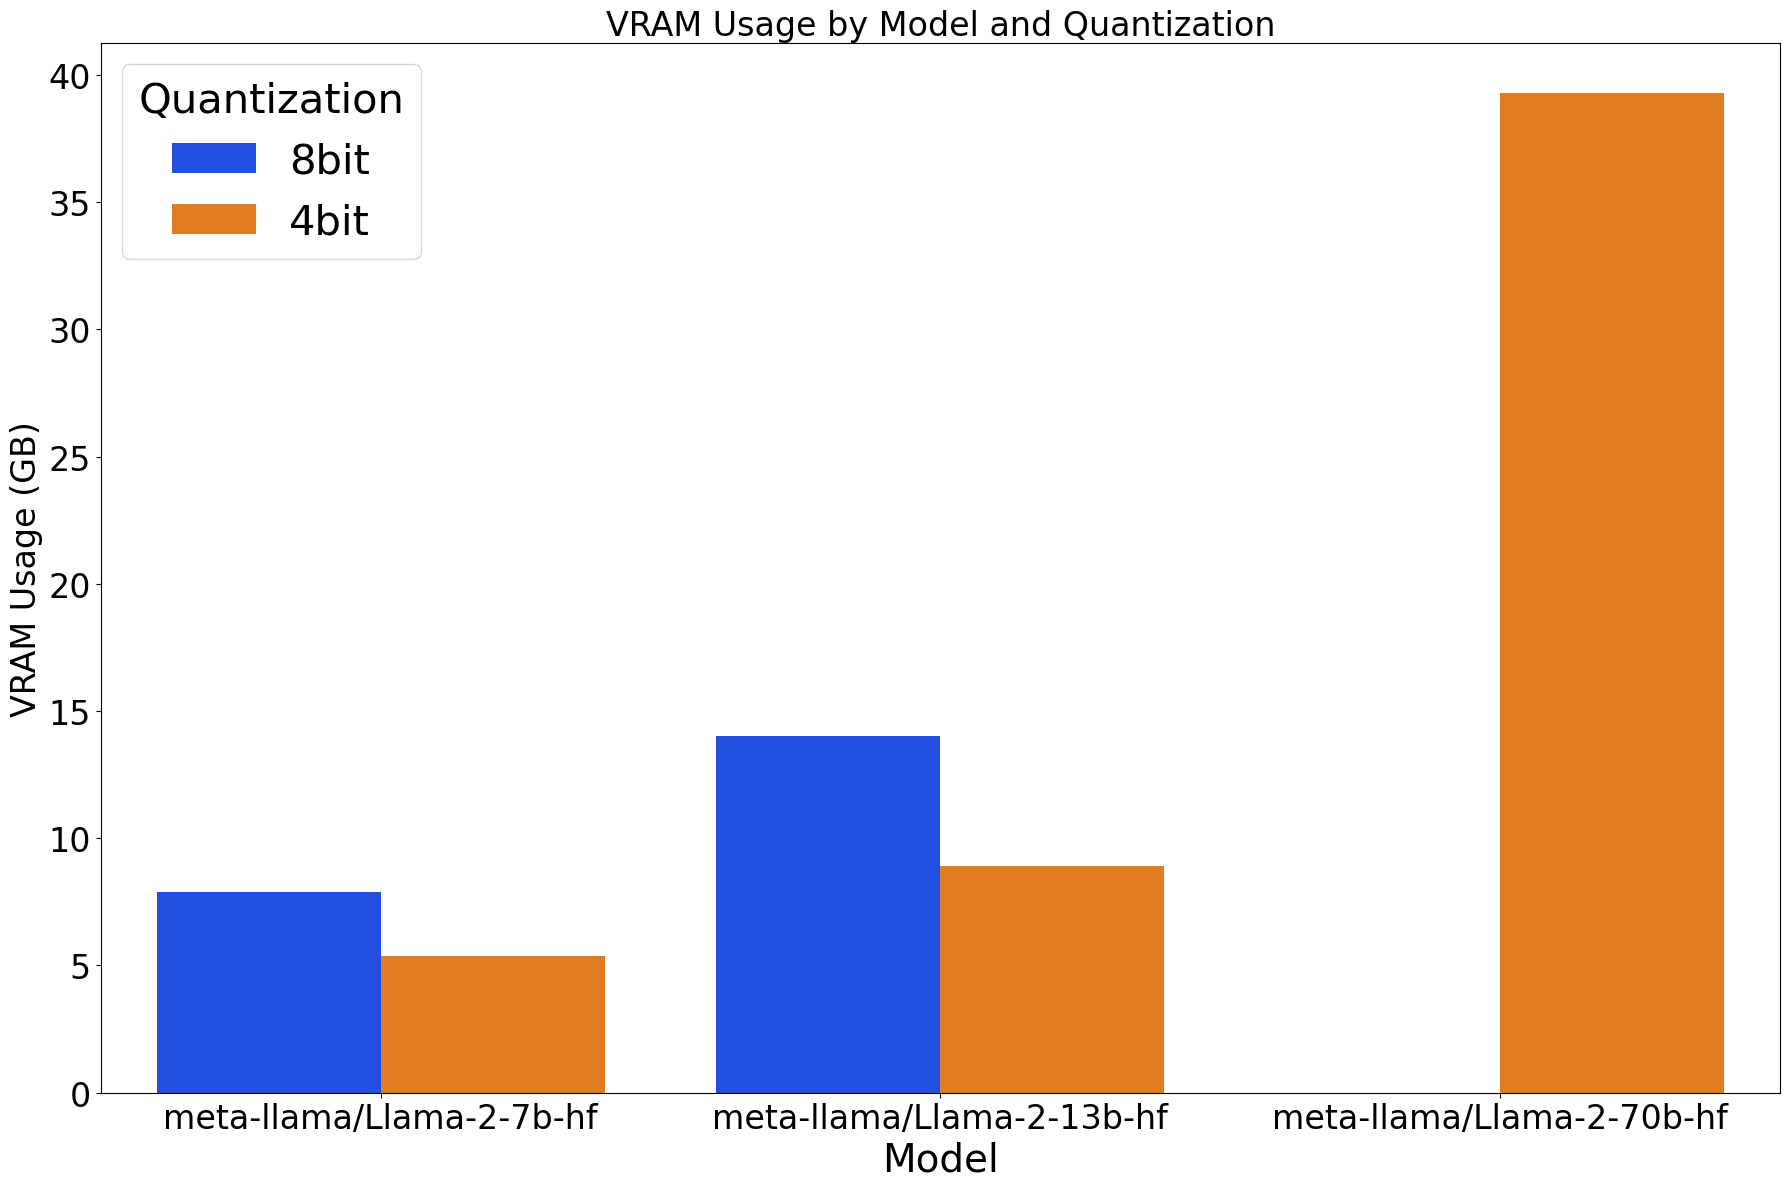

<Figure size 640x480 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

plt.figure(figsize=(18, 12))
sns.barplot(data=df, x="Model", hue="Quantization", y="VRAM Usage with Model (GB)", palette='bright')

plt.title("VRAM Usage by Model and Quantization", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('Model', fontsize=28)
plt.ylabel('VRAM Usage (GB)', fontsize=24)

plt.legend(title="Quantization", title_fontsize=30, fontsize=30)
plt.tight_layout()
plt.show()
plt.savefig("/work/acslab/users/manning/vram.png")

In [7]:
model.device
!nvidia-smi

Mon Sep 18 21:18:00 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe           Off| 00000000:01:00.0 Off |                    0 |
| N/A   40C    P0               68W / 300W|   8063MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [9]:
prompt = "Can you explain computer science to me a if I was 5 years old?"
generated_text = gen_response(prompt)
print(generated_text)

Can you explain computer science to me a if I was 5 years old?

Computer science is like playing with toys! Imagine you have a bunch of blocks, Legos, or dolls. You can use them to build things, like a castle or a car. But, instead of using blocks and Legos, we use something called a computer.
A computer is like a big toy box that can do lots of things for us. It can play games, show pictures, and even talk to us! Just like how you can use your toys to make something fun, a computer can use
